### Python implementation of HBV model
```python
HBV is a simple conceptual hydrological model that simulates the main hydrological processes related to snow, soil, groundwater, and routing. There are many software packages and off-the-shelf products that implement it.

I’ve been experimenting with the model lately and——in an endeavour to better understand the logic behind it——I decided to implement my own version —— in Python, following an intuitive object-oriented programming approach.

This can be flexibly used for different modelling tasks, but can also be used in a classroom setup —— to explain hydrological concepts (processes, calibration, uncertainty analysis, etc.).

This notebook walk the reader through how to use this model. It follows bulding a model and calibrating it and estimating the uncertainity for a case study.

### Getting Started

```python
"""
HBV Hydrological Model

This module integrates the snow, soil, and response routines (routing routine yet to be implemented) into a complete
HBV-like hydrological model. It handles parameter management, data reading, model
execution, calibration, uncertainity and output visualization.

Usage:

    from hbv_model import HBVModel
    model = HBVModel()
    model.load_data("pandas dataframe")
    model.set_parameters(params)
    model.run()
    model.calibrate()
    model.evaluate_uncertainity()
    model.plot_results()
    model.save_results()
    model.save_model("path")
    model.load_model("path")

It is very intiuitive——the model is like an object which has attributes (data, parameters, initial_conditions, etc.) that you can assign and access. The object also performs functions (calibration, uncertainity estimation, save, load, etc.)    

"""

### Import the Required Functions

In [1]:
from hbv_model import HBVModel
import pandas as pd
import matplotlib.pyplot as plt 

### Read the Data into a Pandas Dataframe

In [2]:
# Read the dat from excel or csv with pands and save into dataframe
data = pd.read_excel('./data/test_data_ubnb.xlsx') 
data.head(5) 

,Date,Q,P,T,PET
0,1981-01-15,0.103,0.1,21.9,0.24
1,1981-01-16,0.100,0.1,21.9,0.24
2,1981-01-17,0.099,0.0,21.9,0.24
3,1981-01-18,0.099,0.5,21.9,0.24
4,1981-01-19,0.096,0.5,21.9,0.24


### Build an HBV Model
```python 
We will define an HBV model for the calibration period (start_date='1981-01-01', end_date='1983-01-01')
# If you did not define the dates all the data will be used

In [3]:
# 1. Initialize the model
model_calibration = HBVModel()


# # Read the data from pandas df
model_calibration.load_data(data=data,
               date_column='Date',
               precip_column='P',
               temp_column='T',
               pet_column='PET',
               obs_q_column='Q',
               date_format='%Y%m%d',
               start_date='1981-01-01',          
               end_date='2000-01-01',  )  # you can also specify date within your data range
                                          # use the date to split the data for calibration and validatoin

Time step detected: D
Loaded data with 6926 time steps, from 1981-01-15 00:00:00 to 2000-01-01 00:00:00


In [4]:
model_calibration.data.head(5)

,Date,Q,P,T,PET
0,1981-01-15,0.103,0.1,21.9,0.24
1,1981-01-16,0.100,0.1,21.9,0.24
2,1981-01-17,0.099,0.0,21.9,0.24
3,1981-01-18,0.099,0.5,21.9,0.24
4,1981-01-19,0.096,0.5,21.9,0.24


### Define Custom Model Parameters

In [5]:
custom_params ={'soil': {'FC': {'min': 10, 'max': 650, 'default': 150},
  'LP': {'min': 0.3, 'max': 1.0, 'default': 0.7859074433357328},
  'BETA': {'min': 1.0, 'max': 150, 'default': 2.997466870294053}},
 'response': {'K0': {'min': 0.00001,
   'max': 0.1,
   'default': 0.1},
  'K1': {'min': 5e-06, 'max': 5e-01, 'default': 0.01},
  'K2': {'min': 5e-07, 'max': 5e-01, 'default': 0.001},
  'UZL': {'min': 0.5, 'max': 150, 'default': 80},
  'PERC': {'min': 0.1, 'max': 1, 'default': 0.35}},
 'snow': {'TT': {'min': -2.0, 'max': 2.0, 'default': 0.0},
  'CFMAX': {'min': 1.0, 'max': 6.0, 'default': 4.0},
  'PCF': {'min': 0.3, 'max': 1.0, 'default': 0.3000003551404905},
  'SFCF': {'min': 0, 'max': 1.5, 'default': 0.3},
  'CFR': {'min': 0.0, 'max': 0.2, 'default': 0.05},
  'CWH': {'min': 0.0, 'max': 0.2, 'default': 0.1}}}
# custom_params ={
#             'snow': {
#                 'TT': {'min': -2.0, 'max': 2.0, 'default': 0.0},
#                 'CFMAX': {'min': 1.0, 'max': 6.0, 'default': 3.5},
#                 'PCF': {'min': 0.3, 'max': 1.5, 'default': 0.67},
#                 'SFCF': {'min': 0.5, 'max': 1.5, 'default': 1.0},
#                 'CFR': {'min': 0.0, 'max': 0.2, 'default': 0.05},
#                 'CWH': {'min': 0.0, 'max': 0.2, 'default': 0.1}
#             },
#             'soil': {
#                 'FC': {'min': 50.0, 'max': 850, 'default': 650},
#                 'LP': {'min': 0.3, 'max': 1.0, 'default': 0.7},
#                 'BETA': {'min': 1.0, 'max': 5.0, 'default': 2.0}
#             },
#             'response': {
#                 'K0': {'min': 0.001, 'max': 0.2, 'default': 0.02},
#                 'K1': {'min': 0.001, 'max': 0.05, 'default': 0.02},
#                 'K2': {'min': 0.00001, 'max': 0.09, 'default': 0.008},
#                 'UZL': {'min': 5.0, 'max': 80.0  , 'default': 20.0},
#                 'PERC': {'min': 0.001, 'max': 0.35, 'default': 0.35}
#             }
#         }




#  {'soil': {'FC': {'min': 150, 'max': 850, 'default': 650.0017386452431},
#   'LP': {'min': 0.3, 'max': 1.0, 'default': 0.5433744209416105},
#   'BETA': {'min': 1.0, 'max': 5.0, 'default': 1.0}},
#  'response': {'K0': {'min': 0.01, 'max': 0.9, 'default': 0.022048473791065976},
#   'K1': {'min': 1e-02, 'max': 0.05, 'default': 0.026069428435876396},
#   'K2': {'min': 0.008, 'max': 0.09, 'default': 0.008},
#   'UZL': {'min': 5.0, 'max': 50.0, 'default': 20.031220393700863},
#   'PERC': {'min': 0.1, 'max': 0.5, 'default': 0.35}},
#  'snow': {'TT': {'min': -2.0, 'max': 2.0, 'default': 0.0},
#   'CFMAX': {'min': 1.0, 'max': 6.0, 'default': 3.5},
#   'PCF': {'min': 0.25, 'max': 1.5, 'default': 0.25000000000005507},
#   'SFCF': {'min': 0.5, 'max': 1.5, 'default': 1.0},
#   'CFR': {'min': 0.0, 'max': 0.2, 'default': 0.05},
#   'CWH': {'min': 0.0, 'max': 0.2, 'default': 0.1}}}

model_calibration.set_parameters(custom_params)  # if not set the default parmeters will be used 

### Set the Initial Conditions

In [6]:
# Set initial conditions (if not set default values will be used)

model_calibration.set_initial_conditions(
                                            snowpack=0,  #initial snowpack (mm)
                                            liquid_water=0,    # Initial liquid water in snow (mm)
                                            soil_moisture= 150,  # Initial soil moisture (mm)
                                            upper_storage=10,   # Initial upper zone storage (mm)
                                            lower_storage=20, ) # Initial lower zone storage (mm)

Initial conditions updated.


### Run the Model

In [7]:
# 5. Run the model
results = model_calibration.run() 

Starting model run for 6926 time steps...
Model run completed successfully!
Performance metrics calculated:
NSE: -1.155
KGE: -0.357
PBIAS: 133.9%
Correlation: 0.916


### Visulaize and Save the Resutls

In [8]:
# 6. Visualize results
#model_calibration.plot_results(output_file='./figures/model_results_before_Calibration.png')

#7. Save results to CSV (optional)
# model_calibration.save_results("./results/hbv_uncalibrated_results.csv")

# Save the model for later use
# model_calibration.save_model('./models/ubnb_uncalibrated')

### Calibrate the Model

Starting calibration using SLSQP method...
Optimizing KGE with 14 parameters and 500000000 iterations
Starting model run for 6926 time steps...
Model run completed successfully!
Performance metrics calculated:
NSE: -1.155
KGE: -0.357
PBIAS: 133.9%
Correlation: 0.916
Starting model run for 6926 time steps...
Model run completed successfully!
Performance metrics calculated:
NSE: -1.155
KGE: -0.357
PBIAS: 133.9%
Correlation: 0.916
Starting model run for 6926 time steps...
Model run completed successfully!
Performance metrics calculated:
NSE: -1.155
KGE: -0.357
PBIAS: 133.9%
Correlation: 0.916
Starting model run for 6926 time steps...
Model run completed successfully!
Performance metrics calculated:
NSE: -1.155
KGE: -0.357
PBIAS: 133.9%
Correlation: 0.916
Starting model run for 6926 time steps...
Model run completed successfully!
Performance metrics calculated:
NSE: -1.155
KGE: -0.357
PBIAS: 133.9%
Correlation: 0.916
Starting model run for 6926 time steps...
Model run completed successfull

c:\Users\abdal\anaconda3\Lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Model run completed successfully!
Performance metrics calculated:
NSE: -0.632
KGE: 0.182
PBIAS: 80.5%
Correlation: 0.860
Starting model run for 6926 time steps...
Model run completed successfully!
Performance metrics calculated:
NSE: -0.242
KGE: 0.181
PBIAS: 81.5%
Correlation: 0.924
Starting model run for 6926 time steps...
Model run completed successfully!
Performance metrics calculated:
NSE: -0.198
KGE: 0.254
PBIAS: 74.2%
Correlation: 0.927
Starting model run for 6926 time steps...
Model run completed successfully!
Performance metrics calculated:
NSE: -0.280
KGE: 0.327
PBIAS: 65.8%
Correlation: 0.916
Starting model run for 6926 time steps...
Model run completed successfully!
Performance metrics calculated:
NSE: -0.280
KGE: 0.327
PBIAS: 65.8%
Correlation: 0.916
Starting model run for 6926 time steps...
Model run completed successfully!
Performance metrics calculated:
NSE: -0.280
KGE: 0.327
PBIAS: 65.8%
Correlation: 0.916
Starting model run for 6926 time steps...
Model run completed su

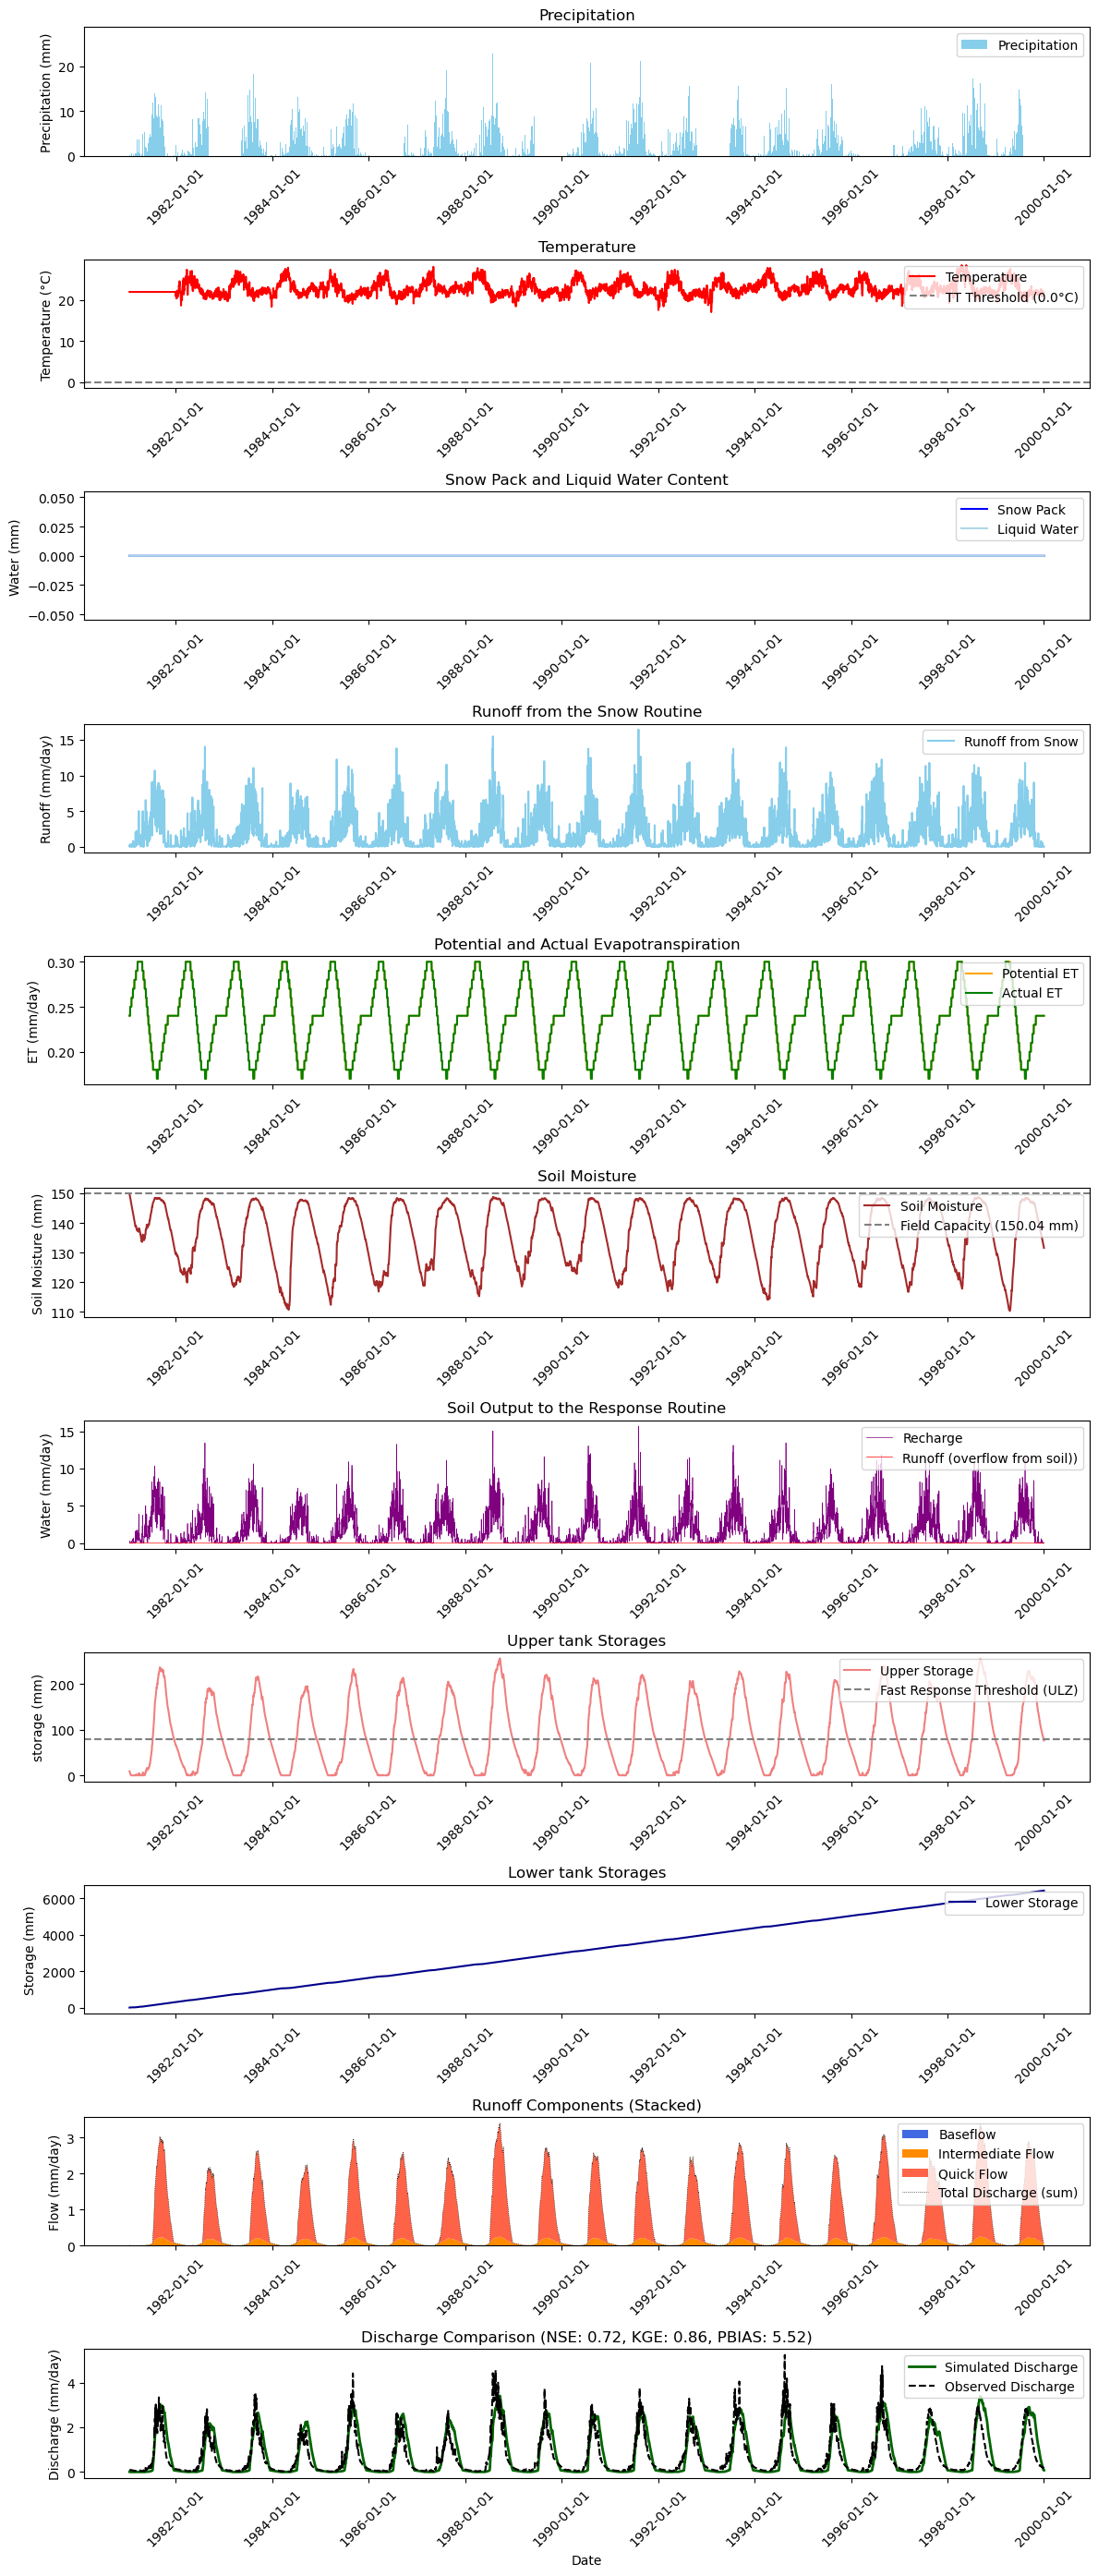

In [9]:
results = model_calibration.calibrate(
    method='SLSQP',     # Optimization algorithm——Options include 'SLSQP', 'L-BFGS-B', 'Nelder-Mead', etc.
    objective='KGE',    # Objective function to optimize
    iterations=500000000,     # Maximum iterations
    verbose=True,       # Print progress
    plot_results=True   # Plot results after calibration
)

# The model now has calibrated parameters
# You can access them via model.params

# You can also access the calibration results
optimized_params = results['parameters']
performance = results['performance']
optimization_details = results['optimization_result']


In [10]:
#model.plot_results(output_file='./figures/model_results_after_calibratoin.png')
#model.save_results(output_file='./results/results_after_calibration.csv')
model_calibration.save_model(output_path='./models/model_calibrated')

Model saved to ./models/model_calibrated


In [11]:
model_calibration.params

{'response': {'K0': {'min': 1e-05,
   'max': 0.1,
   'default': 0.017620001414108685},
  'K1': {'min': 5e-06, 'max': 0.5, 'default': 0.000969137172935888},
  'K2': {'min': 5e-07, 'max': 0.5, 'default': 4.999999999999999e-07},
  'UZL': {'min': 0.5, 'max': 150, 'default': 80.00279288952916},
  'PERC': {'min': 0.1, 'max': 1, 'default': 1.0}},
 'snow': {'TT': {'min': -2.0, 'max': 2.0, 'default': 0.0},
  'CFMAX': {'min': 1.0, 'max': 6.0, 'default': 4.0},
  'PCF': {'min': 0.3, 'max': 1.0, 'default': 0.3},
  'SFCF': {'min': 0, 'max': 1.5, 'default': 0.3},
  'CFR': {'min': 0.0, 'max': 0.2, 'default': 0.05},
  'CWH': {'min': 0.0, 'max': 0.2, 'default': 0.1}},
 'soil': {'FC': {'min': 10, 'max': 650, 'default': 150.03729834013427},
  'LP': {'min': 0.3, 'max': 1.0, 'default': 0.7458987415528273},
  'BETA': {'min': 1.0, 'max': 150, 'default': 2.7302824899675224}}}

### Testing the Model
```python
Now We shall test the Model for the Validation Period (start_date='1983-01-01', end_date='1991-01-01')


In [12]:
# 1. Initialize a model for the validation period 
model_validation = HBVModel()

# # Read the data from pandas df——with the validation dates instead
model_validation.load_data(data=data,
               date_column='Date',
               precip_column='P',
               temp_column='T',
               pet_column='PET',
               obs_q_column='Q',
               date_format='%Y%m%d',
               start_date='2000-01-01',          
               end_date= None,  )      # it is enough to use the start date 
                                       # the model will automatically continue till the end 

Time step detected: D
Loaded data with 2192 time steps, from 2000-01-01 00:00:00 to 2005-12-31 00:00:00


In [13]:
# set the calibrated parameters from the calibrated model
calibrated_parameters = model_calibration.params

# if you have the calibrated model saved you can load it and get its parameters 
# model_cal = HBVModel.load_model("./models/model_calibrated")
# calibrated_parameters = model_cal.params

model_validation.set_parameters(calibrated_parameters)

In [14]:
# Set initial conditions and run the model

model_validation.set_initial_conditions(
                                            snowpack=0,  #initial snowpack (mm)
                                            liquid_water=0,    # Initial liquid water in snow (mm)
                                            soil_moisture= 20,  # Initial soil moisture (mm)
                                            upper_storage=10,   # Initial upper zone storage (mm)
                                            lower_storage= 20, ) # Initial lower zone storage (mm)

results= model_validation.run()   # run the validation model

Initial conditions updated.
Starting model run for 2192 time steps...
Model run completed successfully!
Performance metrics calculated:
NSE: 0.661
KGE: 0.804
PBIAS: 0.6%
Correlation: 0.861


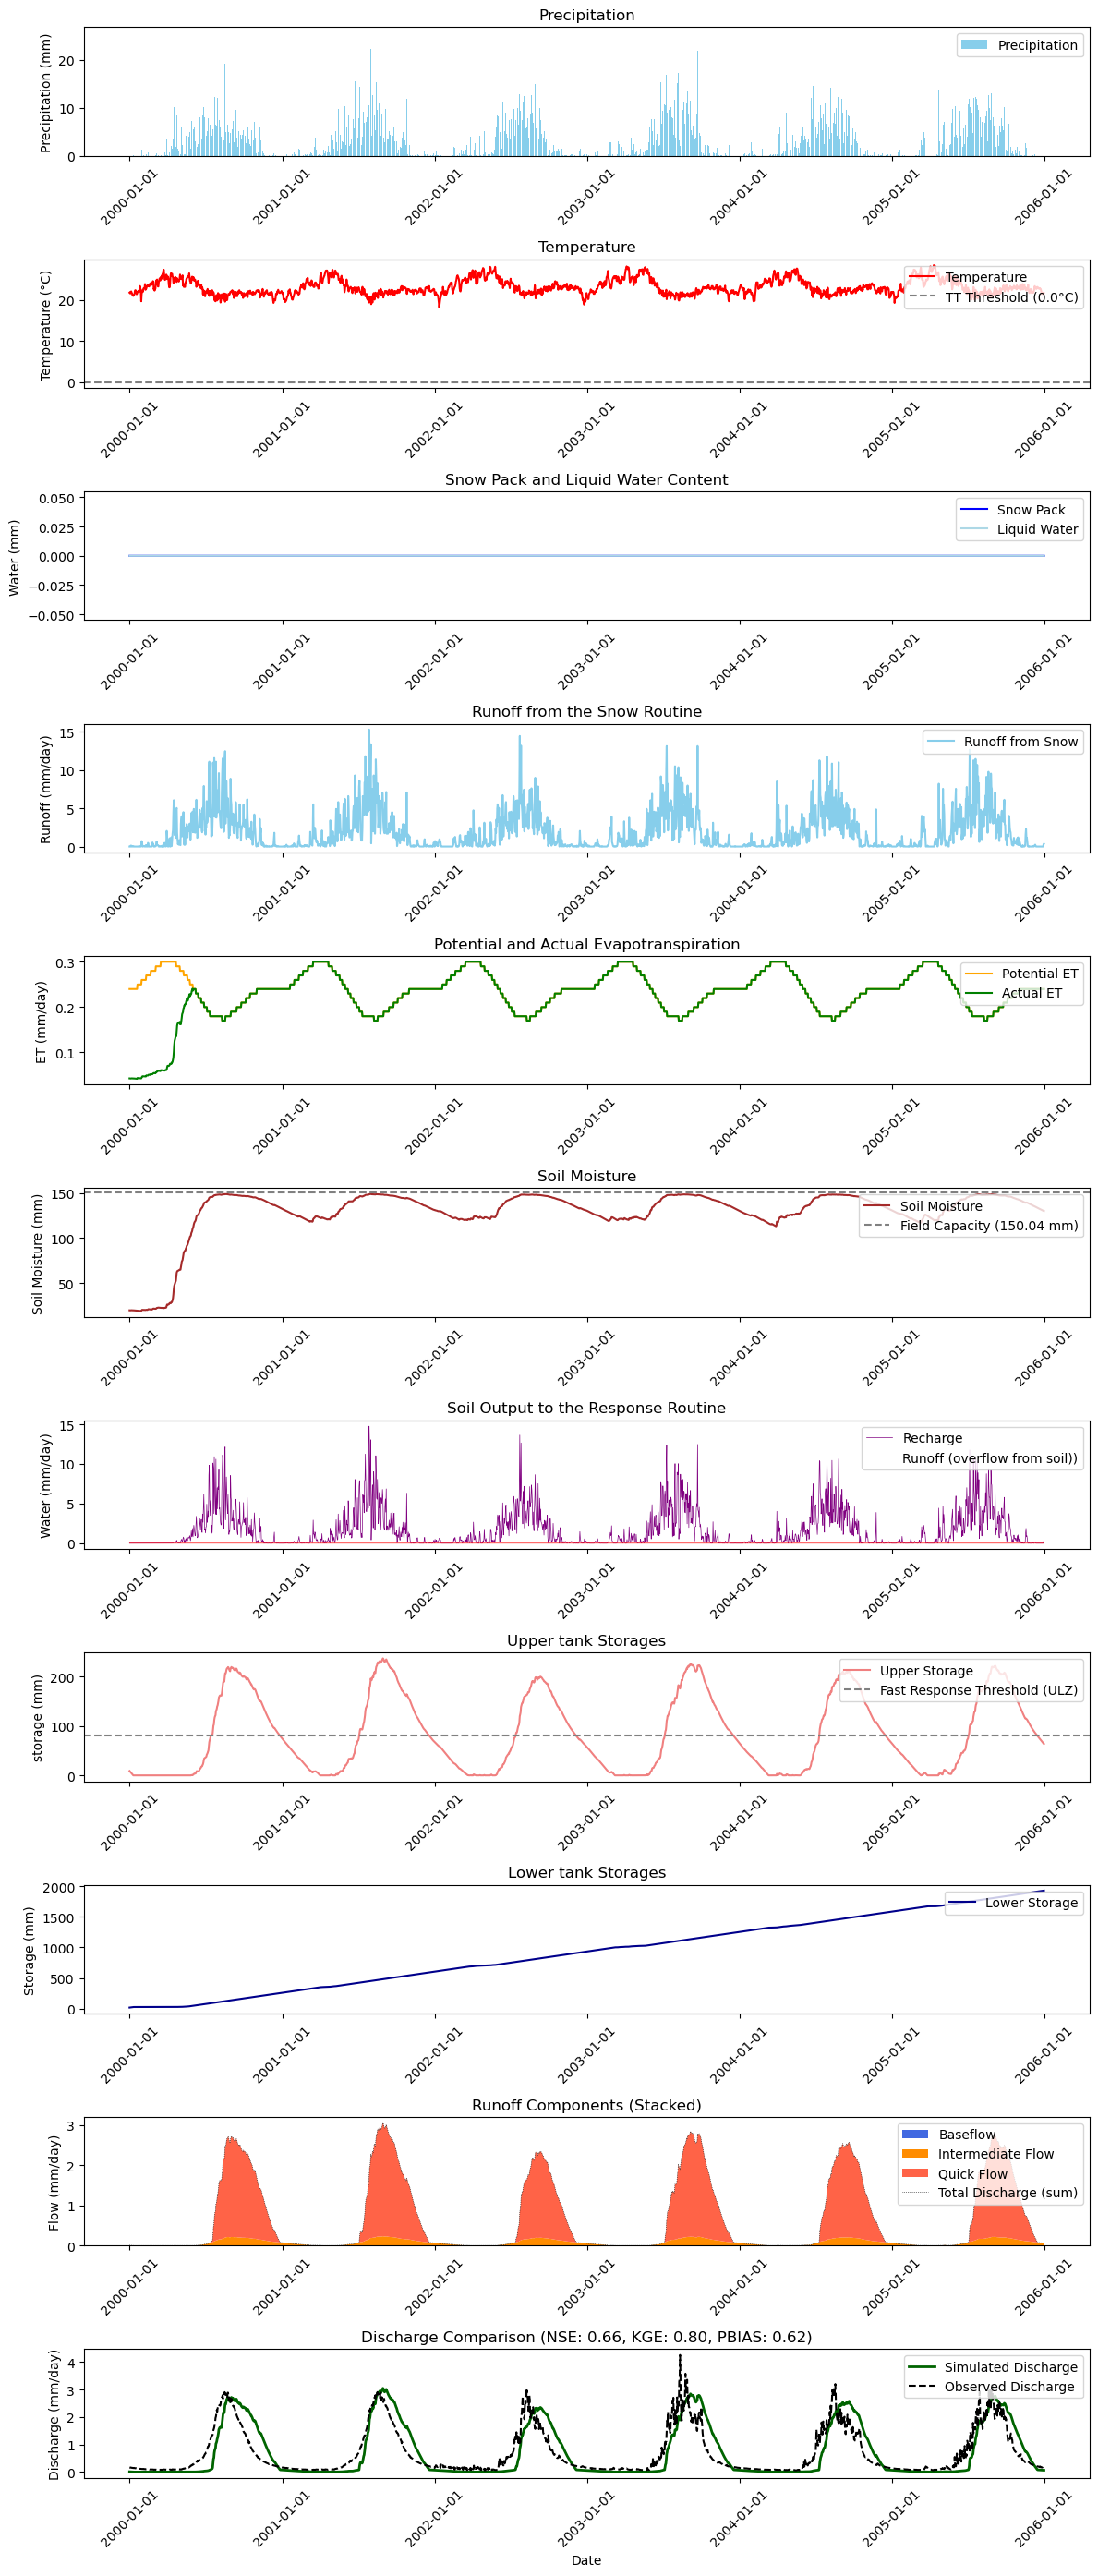

In [15]:
model_validation.plot_results(output_file=None)

### Evaluating the Parameters' Uncertainty 
```python
Now we do the uncertainity analyisis follwing Monte Carlo method. We sample uniformly from the parameters ranges n number of samples and we run the model n times with these samples. Best 10 runs are saved and used for estimating the uncertainity. 

Starting uncertainty analysis with 5000 runs...
Sampling 14 parameters uniformly across their ranges
Evaluating with NSE as the objective function


  0%|          | 0/5000 [00:00<?, ?it/s]

Starting model run for 2192 time steps...
Model run completed successfully!
Performance metrics calculated:
NSE: -49.743
KGE: -4.882
PBIAS: 588.0%
Correlation: 0.913
Performance metrics calculated:
NSE: -49.743
KGE: -4.882
PBIAS: 588.0%
Correlation: 0.913
Starting model run for 2192 time steps...
Model run completed successfully!
Performance metrics calculated:
NSE: -17.127
KGE: -2.040
PBIAS: 303.4%
Correlation: 0.811
Performance metrics calculated:
NSE: -17.127
KGE: -2.040
PBIAS: 303.4%
Correlation: 0.811
Starting model run for 2192 time steps...
Model run completed successfully!
Performance metrics calculated:
NSE: -43.317
KGE: -3.793
PBIAS: 478.8%
Correlation: 0.776
Performance metrics calculated:
NSE: -43.317
KGE: -3.793
PBIAS: 478.8%
Correlation: 0.776
Starting model run for 2192 time steps...
Model run completed successfully!
Performance metrics calculated:
NSE: -16.611
KGE: -1.790
PBIAS: 277.6%
Correlation: 0.739
Performance metrics calculated:
NSE: -16.611
KGE: -1.790
PBIAS: 27

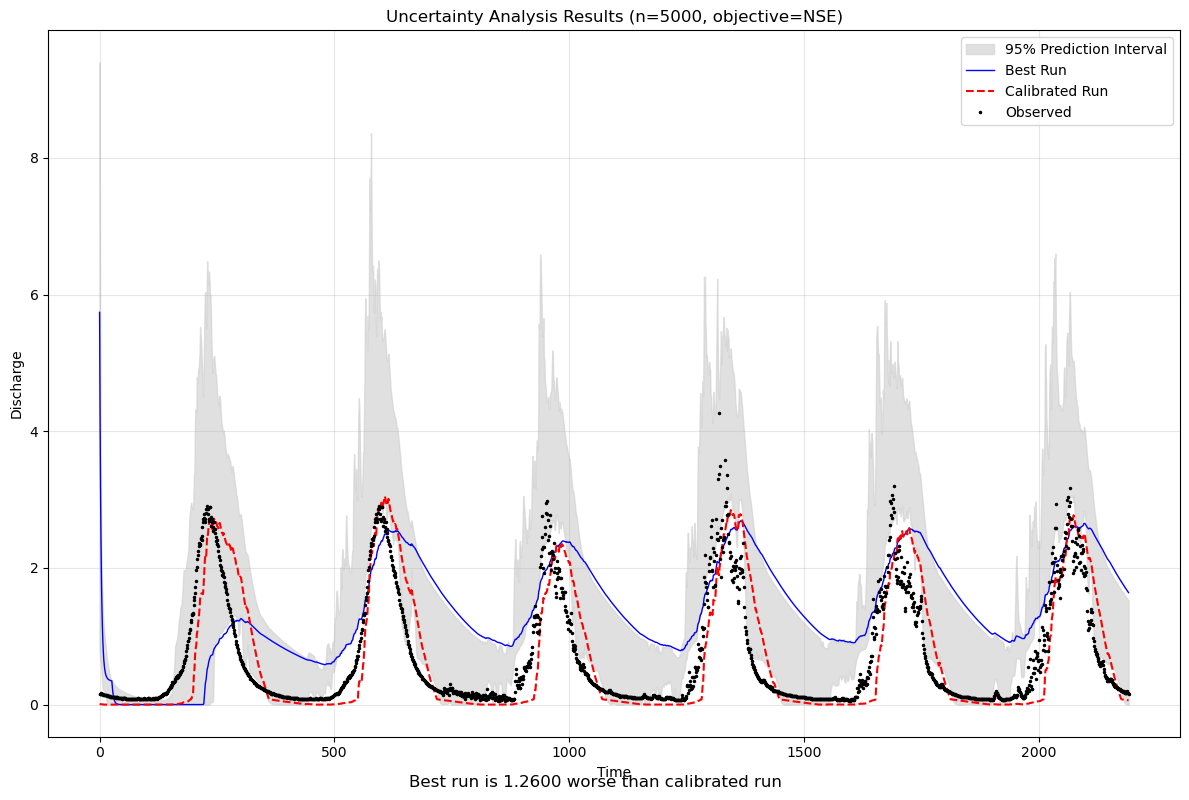

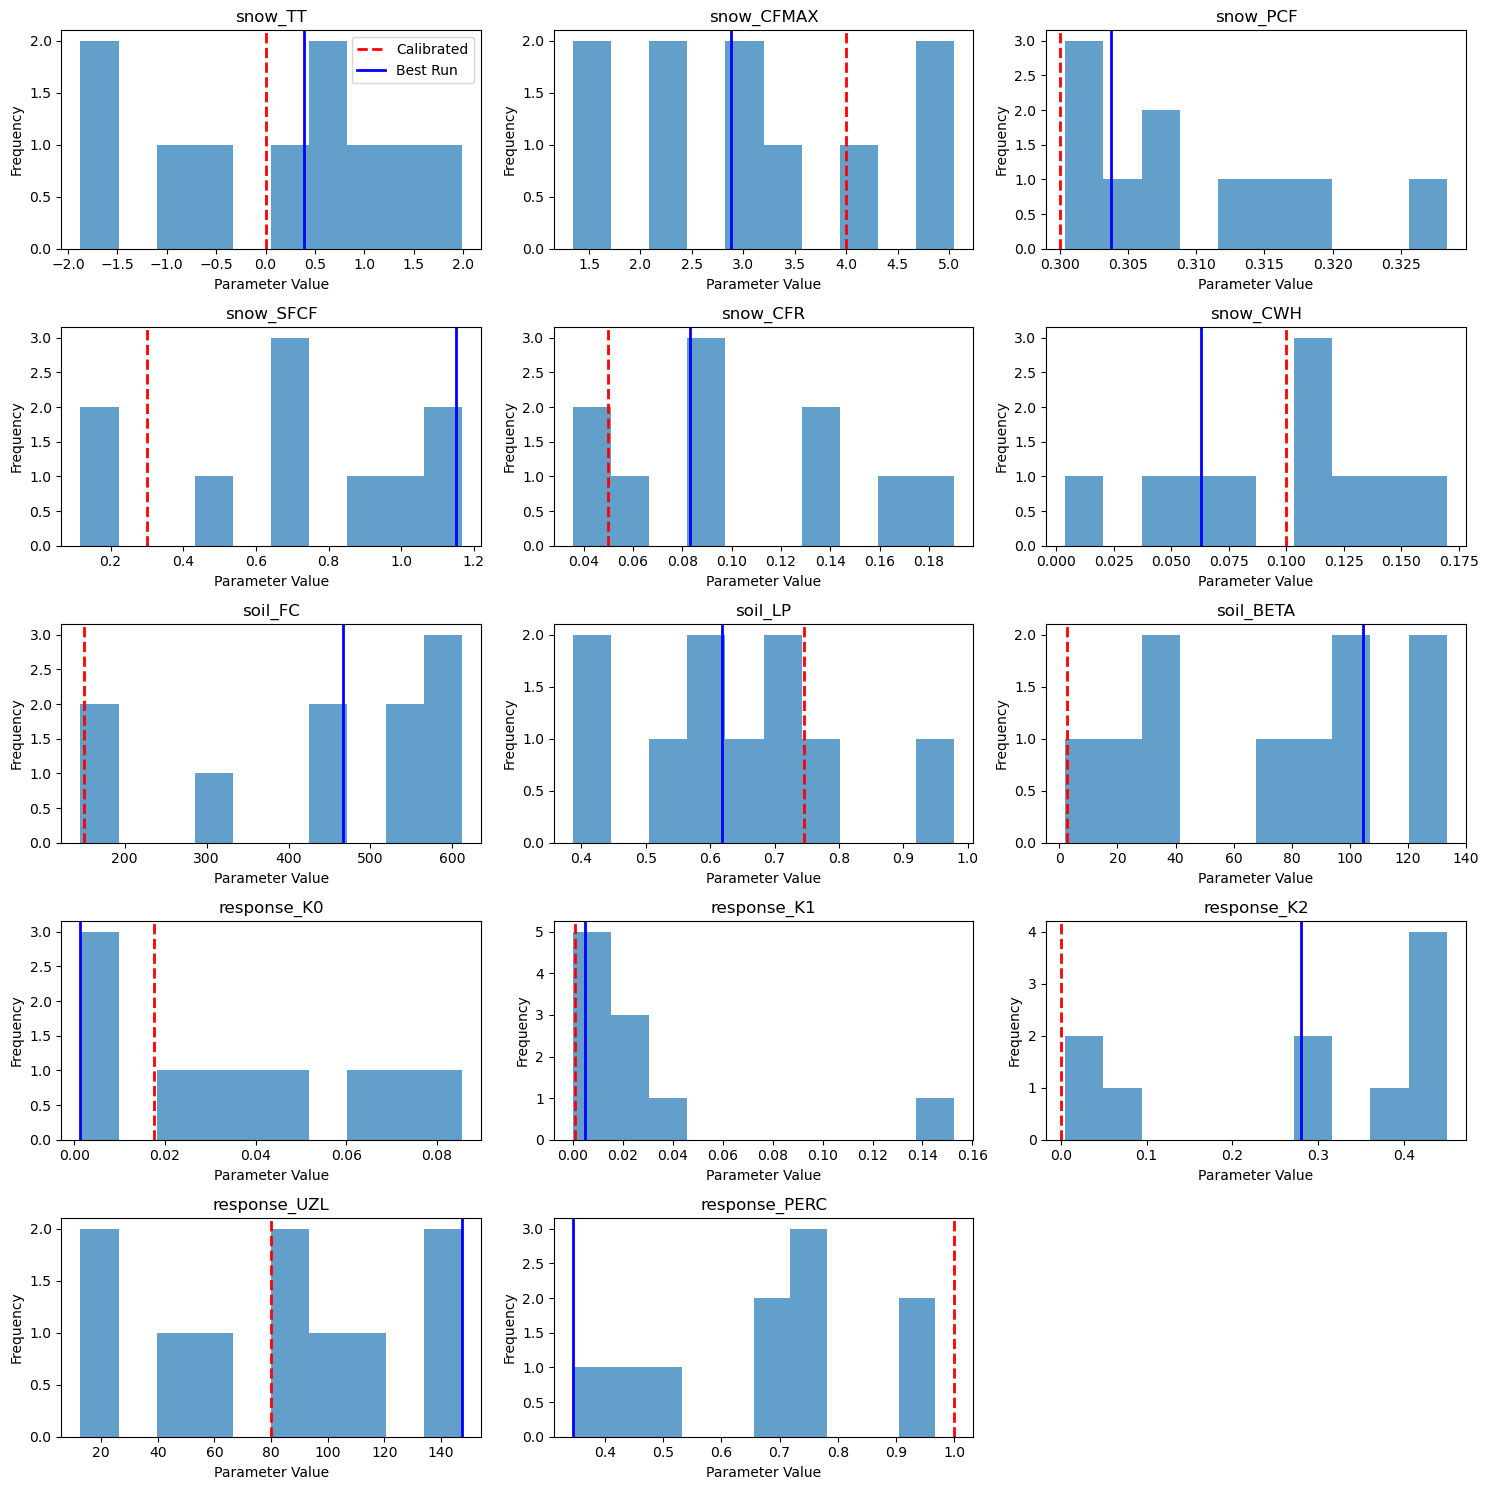


Uncertainty analysis completed in 108.00 seconds
Analyzed 5000 parameter sets

Top Performance Values:
  Run 1: NSE = -0.5988
  Run 2: NSE = -0.9113
  Run 3: NSE = -1.1143
  Run 4: NSE = -1.1494
  Run 5: NSE = -1.3216

Original (Calibrated) Performance: NSE = 0.6611
Best run is 1.2600 worse than calibrated run


In [16]:
# Then run uncertainty analysis
uncertainty_results = model_validation.evaluate_uncertainty(
    n_runs=5000,            # Number of Monte Carlo runs
    objective='NSE',        # Performance metric to use for ranking the model runs
    save_best= 10,           # Number of best parameter sets to save
    plot_results=True,      # Generate visualization
    verbose=True,           # Print progress information
    seed=42                 # Optional random seed for reproducibility
)

In [19]:
custom_params_UBNB ={'response': {'K0': {'min': 0.001,
   'max': 0.1,
   'default': 0.017928309254250915},
  'K1': {'min': 5e-06, 'max': 5e-05, 'default': 5.0004427280349905e-06},
  'K2': {'min': 5e-07, 'max': 5e-06, 'default': 5e-06},
  'UZL': {'min': 1, 'max': 4, 'default': 1.494382401198882},
  'PERC': {'min': 1, 'max': 7, 'default': 4.287418116492705}},
 'soil': {'FC': {'min': 10, 'max': 30, 'default': 24.99995429108948},
  'LP': {'min': 0.3, 'max': 1.0, 'default': 0.7511074936130249},
  'BETA': {'min': 1.0, 'max': 35, 'default': 3.0001846960034175}},
 'snow': {'TT': {'min': -2.0, 'max': 2.0, 'default': 0.0},
  'CFMAX': {'min': 1.0, 'max': 6.0, 'default': 4.0},
  'PCF': {'min': 0.3, 'max': 1.0, 'default': 0.9273536670591036},
  'SFCF': {'min': 0, 'max': 1.5, 'default': 0.3},
  'CFR': {'min': 0.0, 'max': 0.2, 'default': 0.05},
  'CWH': {'min': 0.0, 'max': 0.2, 'default': 0.1}}}
custom_params_lookout = {
    'snow': {
        'TT': {'min': -2.0, 'max': 2.0, 'default': 0.0},      # Temperature threshold for snow/rain (°C)
        'CFMAX': {'min': 1.0, 'max': 6.0, 'default': 4},      # Degree-day factor (mm/°C/day)
        'PCF': {'min': 0.65, 'max': 1.0, 'default': 0.67},      # Precipitation correction factor (-)
        'SFCF': {'min': 0, 'max': 1.5, 'default': 0.3},     # Snowfall correction factor (-)
        'CFR': {'min': 0.0, 'max': 0.2, 'default': 0.05},     # Refreezing coefficient (-)
        'CWH': {'min': 0.0, 'max': 0.2, 'default': 0.1}       # Water holding capacity of snow (-)
    },
    'soil': {
        'FC': {'min': 50.0, 'max': 650, 'default': 450.0},  # Field capacity (mm)
        'LP': {'min': 0.3, 'max': 1.0, 'default': 0.75},      # Limit for potential evaporation (-)
        'BETA': {'min': 1.0, 'max': 35, 'default': 3.0}      # Shape coefficient (-)
    },
    'response': {
        'K0': {'min': 0.01, 'max': 0.9, 'default': 0.12},      # Quick flow recession coefficient (1/day)
        'K1': {'min': 0.05, 'max': 0.5, 'default': 0.05},     # Intermediate flow recession coefficient (1/day)
        'K2': {'min': 0.005, 'max': 0.5, 'default': 0.05},     # Baseflow recession coefficient (1/day)
        'UZL': {'min': 5.0, 'max': 50.0, 'default': 28.0},    # Upper zone threshold (mm)
        'PERC': {'min': 0.03, 'max': 25, 'default': 0.25}     # Percolation rate (mm/day)
    }
}

custom_params_HBV_land ={'response': {'K0': {'min': 0.01, 'max': 0.9, 'default': 0.11323336086000878},
  'K1': {'min': 0.005, 'max': 0.5, 'default': 0.0646675395143037},
  'K2': {'min': 0.0005, 'max': 0.5, 'default': 0.018321217741902936},
  'UZL': {'min': 5.0, 'max': 50.0, 'default': 26.61999369079226},
  'PERC': {'min': 0.03, 'max': 25, 'default': 0.03}},
 'soil': {'FC': {'min': 50.0, 'max': 650, 'default': 449.7368169438645},
  'LP': {'min': 0.3, 'max': 1.0, 'default': 0.7745757831402357},
  'BETA': {'min': 1.0, 'max': 35, 'default': 3.3155189242761236}},
 'snow': {'TT': {'min': -2.0, 'max': 2.0, 'default': -1.099975575374229},
  'CFMAX': {'min': 1.0, 'max': 6.0, 'default': 6.0},
  'PCF': {'min': 0.65, 'max': 1.0, 'default': 1.0},
  'SFCF': {'min': 0, 'max': 1.5, 'default': 1.0368534489917745},
  'CFR': {'min': 0.0, 'max': 0.2, 'default': 0.06867576949957854},
  'CWH': {'min': 0.0, 'max': 0.2, 'default': 0.08436634612318128}}}



In [55]:
model_validation.save_model('test_model')

Model saved to test_model


In [7]:
import pickle
with open('test_model', 'rb') as f:
            model = pickle.load(f)

AttributeError: 'HBVModel' object has no attribute 'calibrate_hbv_model'

In [1]:
from hbv_model import HBVModel
x=HBVModel()
x.save_model('test_model')

Model saved to test_model


In [3]:
x.calibrate

<bound method calibration.calibrate of <hbv_model.HBVModel object at 0x000001F648556750>>

In [4]:
HBVModel.load_model('test_model')

Model loaded from test_model
